In [1]:
#import libraries

import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import os

In [2]:
#set working directory 
path = "/Users/dangngochuy/Desktop/Hertie/Hertie 3rd semester/Machine Learning/Predicting-German-Election/Code/Transformed Data"
os.chdir(path)

#load data
afd = pd.read_csv("combined_data_afd.csv", index_col='date', parse_dates=True)
cdu = pd.read_csv("combined_data_cdu.csv", index_col='date', parse_dates=True)
fdp = pd.read_csv("combined_data_fdp.csv", index_col='date', parse_dates=True)
spd = pd.read_csv("combined_data_spd.csv", index_col='date', parse_dates=True)
lin = pd.read_csv("combined_data_lin.csv", index_col='date', parse_dates=True)
gru = pd.read_csv("combined_data_gru.csv", index_col='date', parse_dates=True)
oth = pd.read_csv("combined_data_oth.csv", index_col='date', parse_dates=True)
afd.tail()

support
date                 
2017-09-17  10.350602
2017-09-18  10.416797
2017-09-19  10.482993
2017-09-20  10.527211
2017-09-21  10.571429

### Recurrent Neural Network with LSTM

#### Model architecture¶

1) LSTM with 100 neurons in the first visible layer

3) Dropout rate: 20%

4) 1 neuron in the output layer for predicting public support percentage based on polls.

5) The input shape will be 1 time step with 1 features.

6) Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.

In [3]:
import sys 
from scipy.stats import randint
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score

# Load deep learning libraries:
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

/Users/dangngochuy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W1113 23:14:19.085002 4700442048 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.
W1113 23:14:19.192910 4700442048 __init__.py:335] Limited tf.summary API due to missing TensorBoard installation.
Using TensorFlow backend.


In [4]:
# Create function to transform series data into form suitable for supervised learning input

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### AFD Model

In [5]:
# Get values of AFD voteshares from combined data
afd_values = afd.values 

# normalize features
afd_scaler = MinMaxScaler(feature_range=(0, 1))
afd_scaled = afd_scaler.fit_transform(afd_values)
# frame as supervised learning
afd_reframed = series_to_supervised(afd_scaled, 1, 1)
print(afd_reframed.head())

   var1(t-1)   var1(t)
1   0.154399  0.155029
2   0.155029  0.155659
3   0.155659  0.154780
4   0.154780  0.153901
5   0.153901  0.153022


In [6]:
# split into train and test sets: using the first 2 years of data as training
afd_values = afd_reframed.values
n_train_time = 365*2
afd_train = afd_values[:n_train_time, :]
afd_test = afd_values[n_train_time:, :]

##test = values[n_train_time:n_test_time, :]
# split into input and outputs
afd_train_X, afd_train_y = afd_train[:, :-1], afd_train[:, -1]
afd_test_X, afd_test_y = afd_test[:, :-1], afd_test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
afd_train_X = afd_train_X.reshape((afd_train_X.shape[0], 1, afd_train_X.shape[1]))
afd_test_X = afd_test_X.reshape((afd_test_X.shape[0], 1, afd_test_X.shape[1]))
print(afd_train_X.shape, afd_train_y.shape, afd_test_X.shape, afd_test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/50
730/730 - 2s - loss: 0.0386 - val_loss: 0.3923
Epoch 2/50
730/730 - 0s - loss: 0.0241 - val_loss: 0.3167
Epoch 3/50
730/730 - 0s - loss: 0.0147 - val_loss: 0.2529
Epoch 4/50
730/730 - 0s - loss: 0.0094 - val_loss: 0.2043
Epoch 5/50
730/730 - 0s - loss: 0.0075 - val_loss: 0.1732
Epoch 6/50
730/730 - 0s - loss: 0.0072 - val_loss: 0.1573
Epoch 7/50
730/730 - 0s - loss: 0.0070 - val_loss: 0.1505
Epoch 8/50
730/730 - 0s - loss: 0.0068 - val_loss: 0.1467
Epoch 9/50
730/730 - 0s - loss: 0.0065 - val_loss: 0.1427
Epoch 10/50
730/730 - 0s - loss: 0.0063 - val_loss: 0.1371
Epoch 11/50
730/730 - 0s - loss: 0.0060 - val_loss: 0.1309
Epoch 12/50
730/730 - 0s - loss: 0.0058 - val_loss: 0.1242
Epoch 13/50
730/730 - 0s - loss: 0.0056 - val_loss: 0.1176
Epoch 14/50
730/730 - 0s - loss: 0.0051 - val_loss: 0.1109
Epoch 15/50
730/730 - 0s - loss: 0.0051 - val_loss: 0.1045
Epoch 16/50
730/730 - 0s - loss: 0.0048 - val_loss: 0.0983
Epoch 17/50
730/730

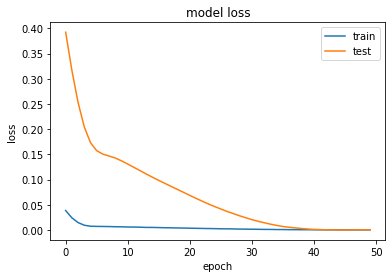

Test RMSE: 0.266


In [7]:
afd_model = tf.keras.models.Sequential()
afd_model.add(tf.keras.layers.LSTM(100, input_shape=(afd_train_X.shape[1], afd_train_X.shape[2])))
afd_model.add(tf.keras.layers.Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
afd_model.add(tf.keras.layers.Dense(1))
afd_model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = afd_model.fit(afd_train_X, afd_train_y, epochs=50, batch_size=70, validation_data=(afd_test_X, afd_test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
afd_yhat = afd_model.predict(afd_test_X)
afd_test_X = afd_test_X.reshape((afd_test_X.shape[0], 1))
# invert scaling for forecast
afd_inv_yhat = np.concatenate((afd_yhat, afd_test_X[:, -6:]), axis=1)
afd_inv_yhat = afd_scaler.inverse_transform(afd_inv_yhat)
afd_inv_yhat = afd_inv_yhat[:,0]

# invert scaling for actual
afd_test_y = afd_test_y.reshape((len(afd_test_y), 1))
afd_inv_y = np.concatenate((afd_test_y, afd_test_X[:, -6:]), axis=1)
afd_inv_y = afd_scaler.inverse_transform(afd_inv_y)
afd_inv_y = afd_inv_y[:,0]

# calculate RMSE
afd_rmse = np.sqrt(mean_squared_error(afd_inv_y, afd_inv_yhat))
print('Test RMSE: %.3f' % afd_rmse)

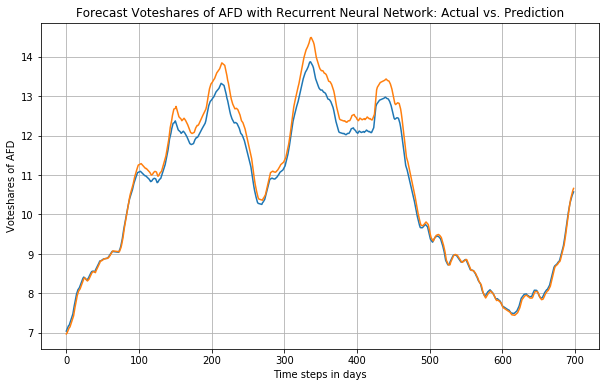

In [8]:
# Timesteps for test set
aa=[x for x in range(699)]

# Create function to plot prediction against actual values
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time steps in days")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of AFD")
plt.title("Forecast Voteshares of AFD with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, afd_inv_y[:699])
plot_series(aa, afd_inv_yhat[:699])

In [9]:
#Using the value of the last timestep, make prediction on the next day of voteshare for AFD

afd_new_test_X = np.array([0.67971706])
afd_new_test_X = afd_new_test_X.reshape((1, 1, 1))
afd_new_yhat1 = afd_model.predict(afd_new_test_X)

#Make prediction on the 2nd next day 
afd_new_yhat1 = afd_new_yhat1.reshape((1, 1, 1))
afd_new_yhat2 = afd_model.predict(afd_new_yhat1)

#Make prediction on the day of election - September 24th, 2017
afd_new_yhat2 = afd_new_yhat2.reshape((1, 1, 1))
afd_new_yhat3 = afd_model.predict(afd_new_yhat2)

#Invert scaling to get predicted result of election date for AFD
afd_inv_yhat3 = afd_scaler.inverse_transform(afd_new_yhat3)
afd_inv_yhat3 = afd_inv_yhat3[:,0]
print("Voteshares of AFD on election day: ", afd_inv_yhat3)

Voteshares of AFD on election day:  [10.970577]


In [10]:
# Feed in actual election result for AFD
afd_actual_y = np.array([12.6])

# calculate RMSE
rmse_afd = np.sqrt(mean_squared_error(afd_actual_y, afd_inv_yhat3))
print('AFD RMSE: %.3f' % rmse_afd)

AFD RMSE: 1.629


### CDU Model

In [11]:
#Get values
cdu_values = cdu.values 

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(cdu_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)   var1(t)
1   0.954286  0.945745
2   0.945745  0.937204
3   0.937204  0.932839
4   0.932839  0.928475
5   0.928475  0.928265


In [12]:
# split into train and test sets
values = reframed.values

n_train_time = 365*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/350
730/730 - 2s - loss: 0.7502 - val_loss: 0.1024
Epoch 2/350
730/730 - 0s - loss: 0.6018 - val_loss: 0.0732
Epoch 3/350
730/730 - 0s - loss: 0.4689 - val_loss: 0.0506
Epoch 4/350
730/730 - 0s - loss: 0.3511 - val_loss: 0.0349
Epoch 5/350
730/730 - 0s - loss: 0.2422 - val_loss: 0.0276
Epoch 6/350
730/730 - 0s - loss: 0.1518 - val_loss: 0.0302
Epoch 7/350
730/730 - 0s - loss: 0.0809 - val_loss: 0.0428
Epoch 8/350
730/730 - 0s - loss: 0.0354 - val_loss: 0.0621
Epoch 9/350
730/730 - 0s - loss: 0.0119 - val_loss: 0.0813
Epoch 10/350
730/730 - 0s - loss: 0.0050 - val_loss: 0.0943
Epoch 11/350
730/730 - 0s - loss: 0.0042 - val_loss: 0.1000
Epoch 12/350
730/730 - 0s - loss: 0.0041 - val_loss: 0.1005
Epoch 13/350
730/730 - 0s - loss: 0.0039 - val_loss: 0.0985
Epoch 14/350
730/730 - 0s - loss: 0.0042 - val_loss: 0.0968
Epoch 15/350
730/730 - 0s - loss: 0.0044 - val_loss: 0.0961
Epoch 16/350
730/730 - 0s - loss: 0.0040 - val_loss: 0.0953
Epo

Epoch 137/350
730/730 - 0s - loss: 0.0026 - val_loss: 0.0462
Epoch 138/350
730/730 - 0s - loss: 0.0031 - val_loss: 0.0461
Epoch 139/350
730/730 - 0s - loss: 0.0028 - val_loss: 0.0453
Epoch 140/350
730/730 - 0s - loss: 0.0028 - val_loss: 0.0446
Epoch 141/350
730/730 - 0s - loss: 0.0027 - val_loss: 0.0449
Epoch 142/350
730/730 - 0s - loss: 0.0026 - val_loss: 0.0443
Epoch 143/350
730/730 - 0s - loss: 0.0028 - val_loss: 0.0438
Epoch 144/350
730/730 - 0s - loss: 0.0026 - val_loss: 0.0428
Epoch 145/350
730/730 - 0s - loss: 0.0025 - val_loss: 0.0423
Epoch 146/350
730/730 - 0s - loss: 0.0026 - val_loss: 0.0429
Epoch 147/350
730/730 - 0s - loss: 0.0023 - val_loss: 0.0420
Epoch 148/350
730/730 - 0s - loss: 0.0025 - val_loss: 0.0416
Epoch 149/350
730/730 - 0s - loss: 0.0025 - val_loss: 0.0412
Epoch 150/350
730/730 - 0s - loss: 0.0029 - val_loss: 0.0413
Epoch 151/350
730/730 - 0s - loss: 0.0025 - val_loss: 0.0400
Epoch 152/350
730/730 - 0s - loss: 0.0027 - val_loss: 0.0402
Epoch 153/350
730/730 - 

Epoch 272/350
730/730 - 0s - loss: 0.0018 - val_loss: 0.0092
Epoch 273/350
730/730 - 0s - loss: 0.0018 - val_loss: 0.0089
Epoch 274/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0092
Epoch 275/350
730/730 - 0s - loss: 0.0019 - val_loss: 0.0089
Epoch 276/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0089
Epoch 277/350
730/730 - 0s - loss: 0.0018 - val_loss: 0.0089
Epoch 278/350
730/730 - 0s - loss: 0.0018 - val_loss: 0.0086
Epoch 279/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0086
Epoch 280/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0086
Epoch 281/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0087
Epoch 282/350
730/730 - 0s - loss: 0.0016 - val_loss: 0.0085
Epoch 283/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0082
Epoch 284/350
730/730 - 0s - loss: 0.0018 - val_loss: 0.0087
Epoch 285/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0079
Epoch 286/350
730/730 - 0s - loss: 0.0015 - val_loss: 0.0080
Epoch 287/350
730/730 - 0s - loss: 0.0017 - val_loss: 0.0084
Epoch 288/350
730/730 - 

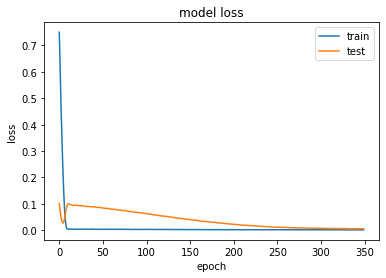

Test RMSE: 0.735


In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=350, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

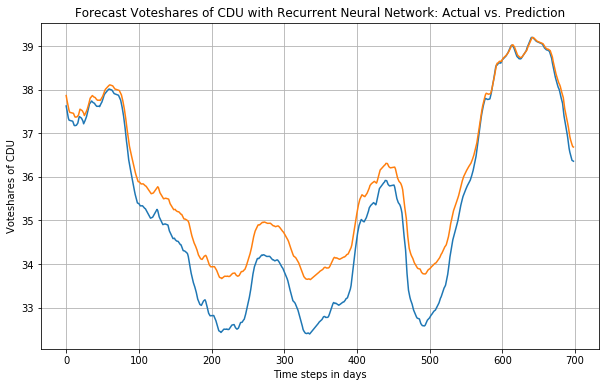

In [14]:
#Plot actual vs. prediction of voteshares

plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of CDU")
plt.title("Forecast Voteshares of CDU with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, inv_y[:699])
plot_series(aa, inv_yhat[:699])

In [15]:
#Using the value of the last timestep, make prediction on the next day of voteshare for CDU
new_test_X = test_X[-1]
new_test_X = new_test_X.reshape((1, 1, 1))
new_yhat1 = model.predict(new_test_X)
print(new_yhat1)

#Make prediction on the 2nd next day 
new_yhat1 = new_yhat1.reshape((1, 1, 1))
new_yhat2 = model.predict(new_yhat1)
print(new_yhat2)

#Make prediction on the day of election - September 24th, 2017
new_yhat2 = new_yhat2.reshape((1, 1, 1))
new_yhat3 = model.predict(new_yhat2)
print(new_yhat3)

#Invert scaling to get predicted result of election date for CDU
inv_yhat3 = scaler.inverse_transform(new_yhat3)
inv_yhat3 = inv_yhat3[:,0]
print(inv_yhat3)

[[0.43640742]]
[[0.46343023]]
[[0.48648345]]
[37.174267]


In [16]:
# Feed in actual election result for CDU
actual_y = np.array([32.9])

# calculate RMSE
rmse_cdu = np.sqrt(mean_squared_error(actual_y, inv_yhat3))
print('CDU RMSE: %.3f' % rmse_cdu)

CDU RMSE: 4.274


### SPD Model

In [17]:
## * Note: I scale all features in range of [0,1].

spd_values = spd.values 

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(spd_values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)   var1(t)
1   0.435005  0.437073
2   0.437073  0.439142
3   0.439142  0.439411
4   0.439411  0.439680
5   0.439680  0.436370


In [18]:
# split into train and test sets
values = reframed.values

n_train_time = 365*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/300
730/730 - 2s - loss: 0.1106 - val_loss: 0.1083
Epoch 2/300
730/730 - 0s - loss: 0.0731 - val_loss: 0.0787
Epoch 3/300
730/730 - 0s - loss: 0.0425 - val_loss: 0.0562
Epoch 4/300
730/730 - 0s - loss: 0.0199 - val_loss: 0.0420
Epoch 5/300
730/730 - 0s - loss: 0.0065 - val_loss: 0.0361
Epoch 6/300
730/730 - 0s - loss: 0.0016 - val_loss: 0.0355
Epoch 7/300
730/730 - 0s - loss: 9.0409e-04 - val_loss: 0.0360
Epoch 8/300
730/730 - 0s - loss: 9.9106e-04 - val_loss: 0.0359
Epoch 9/300
730/730 - 0s - loss: 8.7265e-04 - val_loss: 0.0355
Epoch 10/300
730/730 - 0s - loss: 8.4181e-04 - val_loss: 0.0354
Epoch 11/300
730/730 - 0s - loss: 8.0587e-04 - val_loss: 0.0353
Epoch 12/300
730/730 - 0s - loss: 7.5150e-04 - val_loss: 0.0352
Epoch 13/300
730/730 - 0s - loss: 7.6536e-04 - val_loss: 0.0352
Epoch 14/300
730/730 - 0s - loss: 7.5462e-04 - val_loss: 0.0351
Epoch 15/300
730/730 - 0s - loss: 7.3211e-04 - val_loss: 0.0350
Epoch 16/300
730/730 - 0s -

Epoch 129/300
730/730 - 0s - loss: 5.0750e-04 - val_loss: 0.0190
Epoch 130/300
730/730 - 0s - loss: 5.1587e-04 - val_loss: 0.0188
Epoch 131/300
730/730 - 0s - loss: 5.0903e-04 - val_loss: 0.0187
Epoch 132/300
730/730 - 0s - loss: 5.5015e-04 - val_loss: 0.0185
Epoch 133/300
730/730 - 0s - loss: 5.5802e-04 - val_loss: 0.0183
Epoch 134/300
730/730 - 0s - loss: 5.2753e-04 - val_loss: 0.0182
Epoch 135/300
730/730 - 0s - loss: 5.1617e-04 - val_loss: 0.0180
Epoch 136/300
730/730 - 0s - loss: 5.0203e-04 - val_loss: 0.0178
Epoch 137/300
730/730 - 0s - loss: 5.2050e-04 - val_loss: 0.0177
Epoch 138/300
730/730 - 0s - loss: 5.3332e-04 - val_loss: 0.0175
Epoch 139/300
730/730 - 0s - loss: 4.9443e-04 - val_loss: 0.0173
Epoch 140/300
730/730 - 0s - loss: 5.0255e-04 - val_loss: 0.0172
Epoch 141/300
730/730 - 0s - loss: 5.4657e-04 - val_loss: 0.0170
Epoch 142/300
730/730 - 0s - loss: 4.8102e-04 - val_loss: 0.0168
Epoch 143/300
730/730 - 0s - loss: 5.2935e-04 - val_loss: 0.0166
Epoch 144/300
730/730 - 0

730/730 - 0s - loss: 2.3790e-04 - val_loss: 0.0023
Epoch 256/300
730/730 - 0s - loss: 2.3553e-04 - val_loss: 0.0023
Epoch 257/300
730/730 - 0s - loss: 2.4281e-04 - val_loss: 0.0022
Epoch 258/300
730/730 - 0s - loss: 2.5162e-04 - val_loss: 0.0022
Epoch 259/300
730/730 - 0s - loss: 2.3798e-04 - val_loss: 0.0022
Epoch 260/300
730/730 - 0s - loss: 2.6374e-04 - val_loss: 0.0021
Epoch 261/300
730/730 - 0s - loss: 2.4219e-04 - val_loss: 0.0020
Epoch 262/300
730/730 - 0s - loss: 2.1632e-04 - val_loss: 0.0020
Epoch 263/300
730/730 - 0s - loss: 2.2604e-04 - val_loss: 0.0019
Epoch 264/300
730/730 - 0s - loss: 2.3453e-04 - val_loss: 0.0019
Epoch 265/300
730/730 - 0s - loss: 2.4045e-04 - val_loss: 0.0018
Epoch 266/300
730/730 - 0s - loss: 2.3224e-04 - val_loss: 0.0018
Epoch 267/300
730/730 - 0s - loss: 2.1723e-04 - val_loss: 0.0018
Epoch 268/300
730/730 - 0s - loss: 2.3404e-04 - val_loss: 0.0017
Epoch 269/300
730/730 - 0s - loss: 2.3509e-04 - val_loss: 0.0016
Epoch 270/300
730/730 - 0s - loss: 2.59

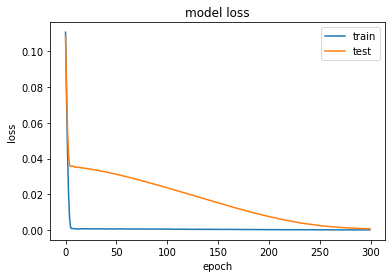

Test RMSE: 0.315


In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

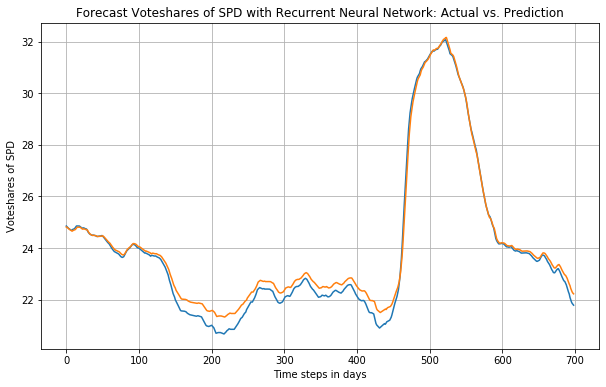

In [20]:
#Plot prediction vs. actual voteshares
plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of SPD")
plt.title("Forecast Voteshares of SPD with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, inv_y[:699])
plot_series(aa, inv_yhat[:699])

In [21]:
#Using the value of the last timestep, make prediction on the next day of voteshare for SPD

new_test_X = test_X[-1]
new_test_X = new_test_X.reshape((1, 1, 1))
new_yhat1 = model.predict(new_test_X)
print(new_yhat1)

#Make prediction on the 2nd next day 
new_yhat1 = new_yhat1.reshape((1, 1, 1))
new_yhat2 = model.predict(new_yhat1)
print(new_yhat2)

#Make prediction on the day of election - September 24th, 2017
new_yhat2 = new_yhat2.reshape((1, 1, 1))
new_yhat3 = model.predict(new_yhat2)
print(new_yhat3)

#Invert scaling to get predicted result of election date for SPD
inv_yhat3 = scaler.inverse_transform(new_yhat3)
inv_yhat3 = inv_yhat3[:,0]
print(inv_yhat3)

[[0.13639061]]
[[0.16493607]]
[[0.18832591]]
[22.816895]


In [22]:
# Feed in actual election result for AFD
actual_y = np.array([20.5])

# calculate RMSE
rmse_spd = np.sqrt(mean_squared_error(actual_y, inv_yhat3))
print('SPD RMSE: %.3f' % rmse_spd)

SPD RMSE: 2.317


### Die Linke Party Model

In [23]:
lin_values = lin.values 

# normalize features
lin_scaler = MinMaxScaler(feature_range=(0, 1))
lin_scaled = scaler.fit_transform(lin_values)
# frame as supervised learning
reframed = series_to_supervised(lin_scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)   var1(t)
1   0.603865  0.596522
2   0.596522  0.589179
3   0.589179  0.581836
4   0.581836  0.574493
5   0.574493  0.575845


In [24]:
# split into train and test sets
values = reframed.values
n_train_time = 365*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/100
730/730 - 2s - loss: 0.2979 - val_loss: 0.2489
Epoch 2/100
730/730 - 0s - loss: 0.2162 - val_loss: 0.1768
Epoch 3/100
730/730 - 0s - loss: 0.1454 - val_loss: 0.1158
Epoch 4/100
730/730 - 0s - loss: 0.0876 - val_loss: 0.0682
Epoch 5/100
730/730 - 0s - loss: 0.0441 - val_loss: 0.0370
Epoch 6/100
730/730 - 0s - loss: 0.0186 - val_loss: 0.0220
Epoch 7/100
730/730 - 0s - loss: 0.0078 - val_loss: 0.0180
Epoch 8/100
730/730 - 0s - loss: 0.0060 - val_loss: 0.0179
Epoch 9/100
730/730 - 0s - loss: 0.0056 - val_loss: 0.0179
Epoch 10/100
730/730 - 0s - loss: 0.0057 - val_loss: 0.0176
Epoch 11/100
730/730 - 0s - loss: 0.0053 - val_loss: 0.0173
Epoch 12/100
730/730 - 0s - loss: 0.0051 - val_loss: 0.0171
Epoch 13/100
730/730 - 0s - loss: 0.0053 - val_loss: 0.0169
Epoch 14/100
730/730 - 0s - loss: 0.0051 - val_loss: 0.0167
Epoch 15/100
730/730 - 0s - loss: 0.0052 - val_loss: 0.0165
Epoch 16/100
730/730 - 0s - loss: 0.0051 - val_loss: 0.0163
Epo

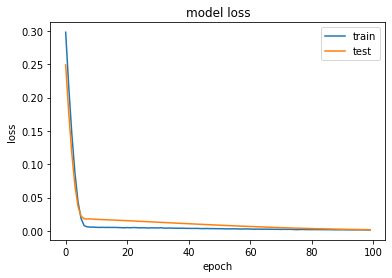

Test RMSE: 0.097


In [25]:
# Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#  ake a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

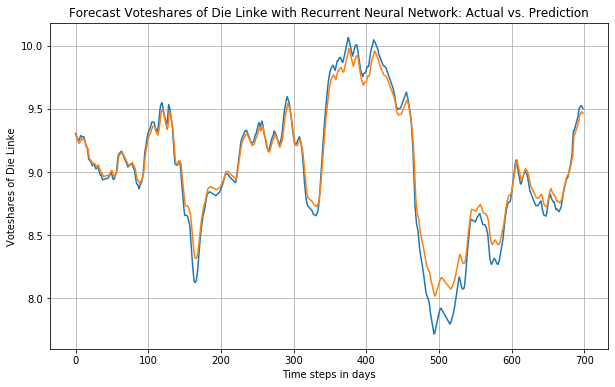

In [26]:
plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of Die Linke")
plt.title("Forecast Voteshares of Die Linke with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, inv_y[:699])
plot_series(aa, inv_yhat[:699])

In [27]:
#Using the value of the last timestep, make prediction on the next day of voteshare for Die Linke

new_test_X = test_X[-1]
new_test_X = new_test_X.reshape((1, 1, 1))
new_yhat1 = model.predict(new_test_X)
print(new_yhat1)

#Make prediction on the 2nd next day 
new_yhat1 = new_yhat1.reshape((1, 1, 1))
new_yhat2 = model.predict(new_yhat1)
print(new_yhat2)

#Make prediction on the day of election - September 24th, 2017
new_yhat2 = new_yhat2.reshape((1, 1, 1))
new_yhat3 = model.predict(new_yhat2)
print(new_yhat3)

#Invert scaling to get predicted result of election date for Die Linke
inv_yhat3 = scaler.inverse_transform(new_yhat3)
inv_yhat3 = inv_yhat3[:,0]
print(inv_yhat3)

[[0.7439079]]
[[0.7254266]]
[[0.7089181]]
[9.3814745]


In [28]:
# Feed in actual election result for AFD
actual_y = np.array([9.2])

# calculate RMSE
rmse_lin = np.sqrt(mean_squared_error(actual_y, inv_yhat3))
print('Die Linke RMSE: %.3f' % rmse_lin)

Die Linke RMSE: 0.181


### GRU

In [29]:
gru_values = gru.values 

# normalize features
gru_scaler = MinMaxScaler(feature_range=(0, 1))
gru_scaled = scaler.fit_transform(gru_values)
# frame as supervised learning
reframed = series_to_supervised(gru_scaled, 1, 1)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.349323  0.359317
2   0.359317  0.369312
3   0.369312  0.379545
4   0.379545  0.389778
5   0.389778  0.393349


In [30]:
# split into train and test sets
values = reframed.values

n_train_time = 365*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/200
730/730 - 2s - loss: 0.2438 - val_loss: 0.2815
Epoch 2/200
730/730 - 0s - loss: 0.1788 - val_loss: 0.2145
Epoch 3/200
730/730 - 0s - loss: 0.1230 - val_loss: 0.1556
Epoch 4/200
730/730 - 0s - loss: 0.0750 - val_loss: 0.1064
Epoch 5/200
730/730 - 0s - loss: 0.0381 - val_loss: 0.0702
Epoch 6/200
730/730 - 0s - loss: 0.0147 - val_loss: 0.0488
Epoch 7/200
730/730 - 0s - loss: 0.0043 - val_loss: 0.0399
Epoch 8/200
730/730 - 0s - loss: 0.0023 - val_loss: 0.0375
Epoch 9/200
730/730 - 0s - loss: 0.0023 - val_loss: 0.0371
Epoch 10/200
730/730 - 0s - loss: 0.0023 - val_loss: 0.0372
Epoch 11/200
730/730 - 0s - loss: 0.0022 - val_loss: 0.0374
Epoch 12/200
730/730 - 0s - loss: 0.0023 - val_loss: 0.0375
Epoch 13/200
730/730 - 0s - loss: 0.0023 - val_loss: 0.0373
Epoch 14/200
730/730 - 0s - loss: 0.0023 - val_loss: 0.0371
Epoch 15/200
730/730 - 0s - loss: 0.0021 - val_loss: 0.0369
Epoch 16/200
730/730 - 0s - loss: 0.0022 - val_loss: 0.0367
Epo

Epoch 137/200
730/730 - 0s - loss: 9.9201e-04 - val_loss: 0.0085
Epoch 138/200
730/730 - 0s - loss: 0.0010 - val_loss: 0.0083
Epoch 139/200
730/730 - 0s - loss: 9.4066e-04 - val_loss: 0.0081
Epoch 140/200
730/730 - 0s - loss: 9.9220e-04 - val_loss: 0.0079
Epoch 141/200
730/730 - 0s - loss: 0.0010 - val_loss: 0.0079
Epoch 142/200
730/730 - 0s - loss: 9.8423e-04 - val_loss: 0.0076
Epoch 143/200
730/730 - 0s - loss: 9.6507e-04 - val_loss: 0.0075
Epoch 144/200
730/730 - 0s - loss: 9.7387e-04 - val_loss: 0.0073
Epoch 145/200
730/730 - 0s - loss: 8.4454e-04 - val_loss: 0.0071
Epoch 146/200
730/730 - 0s - loss: 9.0529e-04 - val_loss: 0.0070
Epoch 147/200
730/730 - 0s - loss: 9.4799e-04 - val_loss: 0.0069
Epoch 148/200
730/730 - 0s - loss: 9.3185e-04 - val_loss: 0.0067
Epoch 149/200
730/730 - 0s - loss: 9.5136e-04 - val_loss: 0.0065
Epoch 150/200
730/730 - 0s - loss: 8.7699e-04 - val_loss: 0.0064
Epoch 151/200
730/730 - 0s - loss: 8.6849e-04 - val_loss: 0.0063
Epoch 152/200
730/730 - 0s - loss

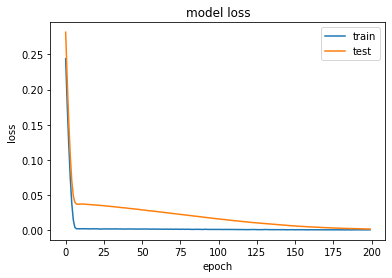

Test RMSE: 0.265


In [31]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

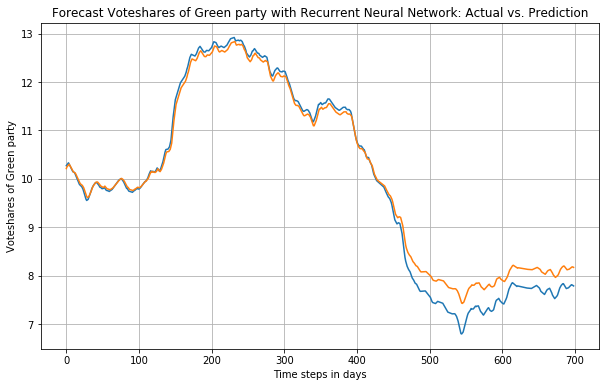

In [32]:
plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of Green party")
plt.title("Forecast Voteshares of Green party with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, inv_y[:699])
plot_series(aa, inv_yhat[:699])

In [33]:
#Using the value of the last timestep, make prediction on the next day of voteshare for Green

new_test_X = test_X[-1]
new_test_X = new_test_X.reshape((1, 1, 1))
new_yhat1 = model.predict(new_test_X)
print(new_yhat1)

#Make prediction on the 2nd next day 
new_yhat1 = new_yhat1.reshape((1, 1, 1))
new_yhat2 = model.predict(new_yhat1)
print(new_yhat2)

#Make prediction on the day of election - September 24th, 2017
new_yhat2 = new_yhat2.reshape((1, 1, 1))
new_yhat3 = model.predict(new_yhat2)
print(new_yhat3)

#Invert scaling to get predicted result of election date for Green
inv_yhat3 = scaler.inverse_transform(new_yhat3)
inv_yhat3 = inv_yhat3[:,0]
print(inv_yhat3)

[[0.2245883]]
[[0.27221075]]
[[0.31032392]]
[8.694422]


In [34]:
# Feed in actual election result for AFD
actual_y = np.array([8.9])

# calculate RMSE
rmse_gru = np.sqrt(mean_squared_error(actual_y, inv_yhat3))
print('Green Party RMSE: %.3f' % rmse_gru)

Green Party RMSE: 0.206


### FDP

In [35]:
fdp_values = fdp.values 

# normalize features
fdp_scaler = MinMaxScaler(feature_range=(0, 1))
fdp_scaled = scaler.fit_transform(fdp_values)
# frame as supervised learning
reframed = series_to_supervised(fdp_scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)   var1(t)
1   0.171353  0.172699
2   0.172699  0.174045
3   0.174045  0.172492
4   0.172492  0.170939
5   0.170939  0.169386


In [36]:
# split into train and test sets
values = reframed.values

n_train_time = 365*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/50
730/730 - 2s - loss: 0.0372 - val_loss: 0.2839
Epoch 2/50
730/730 - 0s - loss: 0.0211 - val_loss: 0.2163
Epoch 3/50
730/730 - 0s - loss: 0.0111 - val_loss: 0.1631
Epoch 4/50
730/730 - 0s - loss: 0.0067 - val_loss: 0.1268
Epoch 5/50
730/730 - 0s - loss: 0.0059 - val_loss: 0.1072
Epoch 6/50
730/730 - 0s - loss: 0.0061 - val_loss: 0.0992
Epoch 7/50
730/730 - 0s - loss: 0.0060 - val_loss: 0.0969
Epoch 8/50
730/730 - 0s - loss: 0.0057 - val_loss: 0.0957
Epoch 9/50
730/730 - 0s - loss: 0.0055 - val_loss: 0.0937
Epoch 10/50
730/730 - 0s - loss: 0.0053 - val_loss: 0.0903
Epoch 11/50
730/730 - 0s - loss: 0.0051 - val_loss: 0.0861
Epoch 12/50
730/730 - 0s - loss: 0.0048 - val_loss: 0.0819
Epoch 13/50
730/730 - 0s - loss: 0.0045 - val_loss: 0.0778
Epoch 14/50
730/730 - 0s - loss: 0.0044 - val_loss: 0.0741
Epoch 15/50
730/730 - 0s - loss: 0.0043 - val_loss: 0.0701
Epoch 16/50
730/730 - 0s - loss: 0.0040 - val_loss: 0.0662
Epoch 17/50
730/730

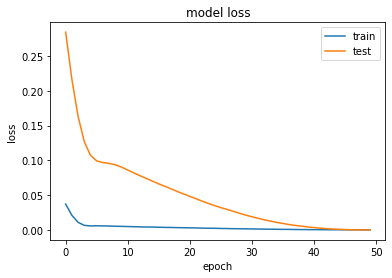

Test RMSE: 0.099


In [37]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

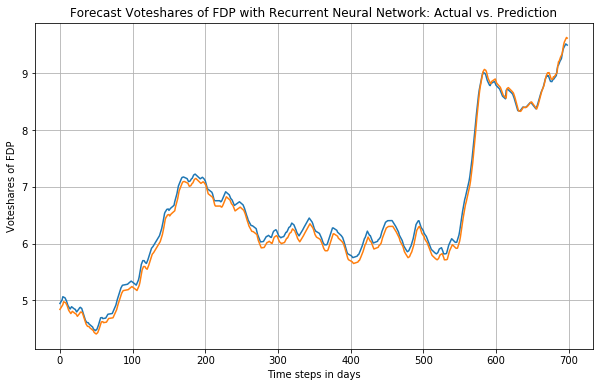

In [38]:
plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of FDP")
plt.title("Forecast Voteshares of FDP with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, inv_y[:699])
plot_series(aa, inv_yhat[:699])

In [39]:
#Using the value of the last timestep, make prediction on the next day of voteshare for FDP

new_test_X = test_X[-1]
new_test_X = new_test_X.reshape((1, 1, 1))
new_yhat1 = model.predict(new_test_X)

#Make prediction on the 2nd next day 
new_yhat1 = new_yhat1.reshape((1, 1, 1))
new_yhat2 = model.predict(new_yhat1)

#Make prediction on the day of election - September 24th, 2017
new_yhat2 = new_yhat2.reshape((1, 1, 1))
new_yhat3 = model.predict(new_yhat2)

#Invert scaling to get predicted result of election date for FDP
inv_yhat3 = scaler.inverse_transform(new_yhat3)
inv_yhat3 = inv_yhat3[:,0]
print(inv_yhat3)

[9.891278]


In [40]:
# Feed in actual election result for AFD
actual_y = np.array([10.7])

# calculate RMSE
rmse_fdp = np.sqrt(mean_squared_error(actual_y, inv_yhat3))
print('FDP RMSE: %.3f' % rmse_fdp)

FDP RMSE: 0.809


### Other Parties

In [41]:
oth_values = oth.values 

# normalize features
oth_scaler = MinMaxScaler(feature_range=(0, 1))
oth_scaled = scaler.fit_transform(oth_values)
# frame as supervised learning
reframed = series_to_supervised(oth_scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())

   var1(t-1)   var1(t)
1   0.739742  0.739823
2   0.739823  0.739905
3   0.739905  0.745137
4   0.745137  0.750368
5   0.750368  0.762956


In [42]:
# split into train and test sets
values = reframed.values

n_train_time = 365*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(730, 1, 1) (730,) (699, 1, 1) (699,)


Train on 730 samples, validate on 699 samples
Epoch 1/300
730/730 - 2s - loss: 0.5598 - val_loss: 0.1566
Epoch 2/300
730/730 - 0s - loss: 0.5200 - val_loss: 0.1410
Epoch 3/300
730/730 - 0s - loss: 0.4812 - val_loss: 0.1263
Epoch 4/300
730/730 - 0s - loss: 0.4425 - val_loss: 0.1123
Epoch 5/300
730/730 - 0s - loss: 0.4067 - val_loss: 0.0991
Epoch 6/300
730/730 - 0s - loss: 0.3710 - val_loss: 0.0866
Epoch 7/300
730/730 - 0s - loss: 0.3367 - val_loss: 0.0749
Epoch 8/300
730/730 - 0s - loss: 0.3022 - val_loss: 0.0639
Epoch 9/300
730/730 - 0s - loss: 0.2717 - val_loss: 0.0538
Epoch 10/300
730/730 - 0s - loss: 0.2387 - val_loss: 0.0446
Epoch 11/300
730/730 - 0s - loss: 0.2097 - val_loss: 0.0364
Epoch 12/300
730/730 - 0s - loss: 0.1803 - val_loss: 0.0294
Epoch 13/300
730/730 - 0s - loss: 0.1535 - val_loss: 0.0237
Epoch 14/300
730/730 - 0s - loss: 0.1269 - val_loss: 0.0194
Epoch 15/300
730/730 - 0s - loss: 0.1037 - val_loss: 0.0166
Epoch 16/300
730/730 - 0s - loss: 0.0825 - val_loss: 0.0153
Epo

Epoch 137/300
730/730 - 0s - loss: 0.0046 - val_loss: 0.0306
Epoch 138/300
730/730 - 0s - loss: 0.0045 - val_loss: 0.0305
Epoch 139/300
730/730 - 0s - loss: 0.0045 - val_loss: 0.0302
Epoch 140/300
730/730 - 0s - loss: 0.0045 - val_loss: 0.0301
Epoch 141/300
730/730 - 0s - loss: 0.0044 - val_loss: 0.0299
Epoch 142/300
730/730 - 0s - loss: 0.0044 - val_loss: 0.0298
Epoch 143/300
730/730 - 0s - loss: 0.0045 - val_loss: 0.0297
Epoch 144/300
730/730 - 0s - loss: 0.0044 - val_loss: 0.0296
Epoch 145/300
730/730 - 0s - loss: 0.0047 - val_loss: 0.0294
Epoch 146/300
730/730 - 0s - loss: 0.0044 - val_loss: 0.0292
Epoch 147/300
730/730 - 0s - loss: 0.0048 - val_loss: 0.0291
Epoch 148/300
730/730 - 0s - loss: 0.0045 - val_loss: 0.0290
Epoch 149/300
730/730 - 0s - loss: 0.0042 - val_loss: 0.0289
Epoch 150/300
730/730 - 0s - loss: 0.0044 - val_loss: 0.0286
Epoch 151/300
730/730 - 0s - loss: 0.0044 - val_loss: 0.0283
Epoch 152/300
730/730 - 0s - loss: 0.0045 - val_loss: 0.0280
Epoch 153/300
730/730 - 

Epoch 272/300
730/730 - 0s - loss: 0.0025 - val_loss: 0.0109
Epoch 273/300
730/730 - 0s - loss: 0.0026 - val_loss: 0.0110
Epoch 274/300
730/730 - 0s - loss: 0.0022 - val_loss: 0.0109
Epoch 275/300
730/730 - 0s - loss: 0.0022 - val_loss: 0.0106
Epoch 276/300
730/730 - 0s - loss: 0.0024 - val_loss: 0.0102
Epoch 277/300
730/730 - 0s - loss: 0.0023 - val_loss: 0.0100
Epoch 278/300
730/730 - 0s - loss: 0.0026 - val_loss: 0.0099
Epoch 279/300
730/730 - 0s - loss: 0.0024 - val_loss: 0.0099
Epoch 280/300
730/730 - 0s - loss: 0.0026 - val_loss: 0.0099
Epoch 281/300
730/730 - 0s - loss: 0.0023 - val_loss: 0.0100
Epoch 282/300
730/730 - 0s - loss: 0.0024 - val_loss: 0.0099
Epoch 283/300
730/730 - 0s - loss: 0.0021 - val_loss: 0.0098
Epoch 284/300
730/730 - 0s - loss: 0.0022 - val_loss: 0.0096
Epoch 285/300
730/730 - 0s - loss: 0.0024 - val_loss: 0.0094
Epoch 286/300
730/730 - 0s - loss: 0.0023 - val_loss: 0.0093
Epoch 287/300
730/730 - 0s - loss: 0.0026 - val_loss: 0.0092
Epoch 288/300
730/730 - 

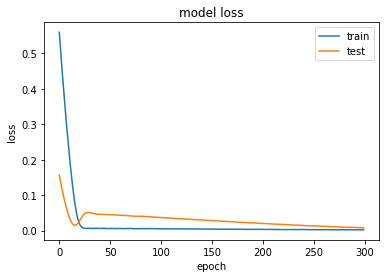

Test RMSE: 0.246


In [43]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

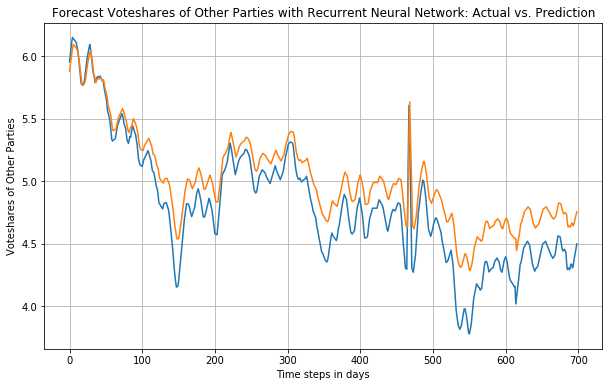

In [44]:
plt.figure(figsize=(10, 6))
plt.ylabel("Voteshares of Other Parties")
plt.title("Forecast Voteshares of Other Parties with Recurrent Neural Network: Actual vs. Prediction")
plot_series(aa, inv_y[:699])
plot_series(aa, inv_yhat[:699])

In [45]:
#Using the value of the last timestep, make prediction on the next day of voteshare for Other parties

new_test_X = test_X[-1]
new_test_X = new_test_X.reshape((1, 1, 1))
new_yhat1 = model.predict(new_test_X)
print(new_yhat1)

#Make prediction on the 2nd next day 
new_yhat1 = new_yhat1.reshape((1, 1, 1))
new_yhat2 = model.predict(new_yhat1)
print(new_yhat2)

#Make prediction on the day of election - September 24th, 2017
new_yhat2 = new_yhat2.reshape((1, 1, 1))
new_yhat3 = model.predict(new_yhat2)
print(new_yhat3)

#Invert scaling to get predicted result of election date for Other parties
inv_yhat3 = scaler.inverse_transform(new_yhat3)
inv_yhat3 = inv_yhat3[:,0]
print(inv_yhat3)

[[0.3525538]]
[[0.42915863]]
[[0.48692316]]
[5.1297092]


In [46]:
# Feed in actual election result for Other parties
actual_y = np.array([5])

# calculate RMSE
rmse_oth = np.sqrt(mean_squared_error(actual_y, inv_yhat3))
print('Other Parties RMSE: %.3f' % rmse_oth)

Other Parties RMSE: 0.130


In [48]:
avg_rmse = (rmse_afd + rmse_spd + rmse_lin + rmse_gru + rmse_fdp + rmse_cdu + rmse_oth) / 7
print("RMSE of AFD Model: ", rmse_afd)
print("RMSE of SPD Model: ", rmse_spd)
print("RMSE of Die Linke Model: ", rmse_lin)
print("RMSE of Green Party Model: ", rmse_gru)
print("RMSE of FDP Model: ", rmse_fdp)
print("RMSE of CDU Model: ", rmse_cdu)
print("RMSE of Other Parties Model: ", rmse_oth)
print("Average RMSE of RNN Model: ", avg_rmse)

RMSE of AFD Model:  1.6294227600097653
RMSE of SPD Model:  2.31689453125
RMSE of Die Linke Model:  0.18147449493408274
RMSE of Green Party Model:  0.2055782318115238
RMSE of FDP Model:  0.808721733093261
RMSE of CDU Model:  4.274266815185548
RMSE of Other Parties Model:  0.12970924377441406
Average RMSE of RNN Model:  1.3637239728655135
